In [1]:
import pandas as pd
import numpy as np
from pandas import read_csv
from pandas import datetime
import matplotlib.pyplot as plt
from pandas.plotting import autocorrelation_plot
import model, model_utils, preprocessing_utils
import torch
import torch.nn as nn

<ipython-input-1-ce94da36370f>:4: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  from pandas import datetime


In [2]:
# if using seasonal ARIMA
m = 12 # 60 minutes

In [37]:
raw_trunc_dir = "./data/raw/trunc/"
process_dir = "./data/processed/"

# overwrite = False means that the processing function will only run if the process data files do not exist
# overwrite = True => functions will run regardless
preprocessing_utils.processed(raw_trunc_dir, process_dir, overwrite=False)
A, X, metadata, cat2index,timestamps, means, stds = preprocessing_utils.load(process_dir)

split_line1 = int(X.shape[2] * 0.6)
split_line2 = int(X.shape[2] * 0.8)

train_original_data = X[:, :, :split_line1]
val_original_data = X[:, :, split_line1:split_line2]
test_original_data = X[:, :, split_line2:]

adj_mat = preprocessing_utils.get_normalized_adj(A)
# adj_mat = torch.from_numpy(adj_mat).to(device)

# Finding the road to be used as comparison

In [38]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

epochs = 500
batch_size = 16
lr = 0.0005920310461116504
patience = 10

num_timesteps_input = 7 # Default is 30 minutes
num_timesteps_output = 4 # Default is 10 minutes

In [39]:
# loaded_model, loaded_optimizer = model_utils.load_model(path=None)
loaded_model, loaded_optimizer = model_utils.load_model(path="saved_models/input8_output4_loss0.6965036988258362")

Loading model in path : saved_models/input8_output4_loss0.6965036988258362


In [129]:
num_timesteps_input = 8
num_timesteps_output = 4
test_input, test_target = preprocessing_utils.generate_dataset(test_original_data,
                                           num_timesteps_input=num_timesteps_input,
                                           num_timesteps_output=num_timesteps_output)
adj_mat = torch.from_numpy(adj_mat).to(device)

TypeError: expected np.ndarray (got Tensor)

In [131]:
from sklearn.metrics import mean_squared_error
import model, model_utils, preprocessing_utils
import math

loaded_model.to(device)
with torch.no_grad():
    predicted = model_utils.predict(loaded_model, test_input, adj_mat)

In [133]:
# Enyi functions
import torch.nn as nn
def rmse_per_link(predicted, actual):
    '''
    Calculates the RMSE of the speedbands for each road separately
    -----------------------------
    :params:
        list (3-dimensions of samples, roads, output timesteps) predicted: The predicted speedbands
        list (3-dimensions of samples, roads, output timesteps) actual: The actual speedbands
    -----------------------------
    :returns:
        list: rmse for each road
    '''
    rmses = []
    for i in range(predicted.shape[1]):
        linkPreds = predicted[:,i,:]
        linkActs = actual[:,i,:]
        rmse = nn.MSELoss()(linkPreds, linkActs).sqrt()
        rmses.append(rmse.item())
    return rmses

In [138]:
predicted_denorm = preprocessing_utils.denormalize(predicted.to("cpu"), stds[0], means[0])
actual_denorm = preprocessing_utils.denormalize(test_target, stds[0], means[0])
stgcn_rmse_per_link = rmse_per_link(predicted_denorm.to(device="cpu"),actual_denorm)
worst_road_index = np.argmax(stgcn_rmse_per_link)
print(stgcn_rmse_per_link[worst_road_index])

1.0277539491653442


# Evaluating ARIMA

In [ ]:
train_original_speedband = train_original_data[:,0,:] # (roads, num_of_timesteps)
val_original_data_speedband = val_original_data[:,0,:] # (roads, num_of_timesteps)
test_original_data_speedband = test_original_data[:,0,:] # (roads, num_of_timesteps)

train = train_original_speedband[0].flatten() # choose only 1 road
val = val_original_data_speedband[0].flatten() # choose only 1 road
test = test_original_data_speedband[0].flatten() # choose only 1 road

train_val = np.append(train,val)
dataAll = np.concatenate([train,val,test])

train_denorm = preprocessing_utils.denormalize(train, stds[0], means[0]).flatten()
train_val_denorm = preprocessing_utils.denormalize(train_val, stds[0], means[0]).flatten()
dataAll_denorm = preprocessing_utils.denormalize(dataAll, stds[0], means[0]).flatten()
test_denorm = preprocessing_utils.denormalize(test, stds[0], means[0]).flatten()

In [162]:
import pmdarima as pm
train_val = np.append(train,val)

# Fit your model
# road 3
road = 3
train_fit = np.concatenate([train_original_speedband[road],val_original_data_speedband[road]])
model = pm.auto_arima(train_fit,
    trace=True,
    suppress_warning=True)

# summary of fit model
print(model.summary())

Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0] intercept   : AIC=14819.051, Time=7.95 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=19299.326, Time=0.09 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=14935.508, Time=0.47 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=16313.746, Time=0.72 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=20170.774, Time=0.05 sec
 ARIMA(1,0,2)(0,0,0)[0] intercept   : AIC=14921.552, Time=1.24 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=14921.700, Time=2.17 sec
 ARIMA(3,0,2)(0,0,0)[0] intercept   : AIC=14876.480, Time=8.48 sec
 ARIMA(2,0,3)(0,0,0)[0] intercept   : AIC=14802.190, Time=7.01 sec
 ARIMA(1,0,3)(0,0,0)[0] intercept   : AIC=14896.876, Time=3.31 sec
 ARIMA(3,0,3)(0,0,0)[0] intercept   : AIC=14808.989, Time=8.06 sec
 ARIMA(2,0,4)(0,0,0)[0] intercept   : AIC=14798.591, Time=7.62 sec
 ARIMA(1,0,4)(0,0,0)[0] intercept   : AIC=14809.961, Time=4.22 sec
 ARIMA(3,0,4)(0,0,0)[0] intercept   : AIC=14806.050, Time=10.77 sec
 ARIMA(2,0,5)(0,0,

In [172]:
# get RMSE
def evaluate_RMSE(model, ):
    # model = ARIMA(,order=(3,1,1))
    num_of_input = 7
    current_input = train_val[-num_of_input:].tolist()

    limit = len(test)
    num_of_pred = 1
    pred = []
    for i in range(0,len(test[:limit]), num_of_pred):
        model.fit(current_input)
        y = model.predict(n_periods=num_of_pred)
        pred.extend(y)

        current_input.pop()
        current_input.extend(test[i:i+1])

def rmse(predictions, targets):
    size = len(predictions)
    diff = predictions - targets
    square = diff ** 2
    rmse = 1/size * (square ** 1/2).sum()
    return np.sqrt(((predictions - targets) ** 2).mean())

In [173]:
def evaluate_arima(model, test_original_data, road, num_timesteps_input, num_timesteps_output):
    """
    params:
        model: 
        test_original_data: list
        road: int
        num_timesteps_input: int
        num_timesteps_output: int
    """
    num_timesteps_input = num_timesteps_input
    num_timesteps_output = num_timesteps_output
    test_input, test_target = preprocessing_utils.generate_dataset(test_original_data,
                                           num_timesteps_input=num_timesteps_input,
                                           num_timesteps_output=num_timesteps_output)
    road = road # worst road
    total_road = 53

    print(f"Evaluating road {road}")
    
    all_predictions = []
    all_actuals = []
    
    for x,y in zip(test_input[:,:,:,0],test_target):
    #     m = ARIMA(x[road].numpy(),order=order)
    #     m_fit = m.fit()
    #     output = m_fit.forecast(steps=num_timesteps_output)
        m_fit = model.fit(x[road].numpy())
        output = m_fit.predict(n_periods=num_timesteps_output)

        # denormalise
        predictions = preprocessing_utils.denormalize(output, stds[0], means[0]).flatten()
        actuals = preprocessing_utils.denormalize(y[road], stds[0], means[0]).flatten()
        
        all_predictions.append(predictions)
        all_actuals.append(actuals.numpy())
        
    # calculate RMSE
    rmse = nn.MSELoss()(torch.tensor(all_predictions), torch.tensor(all_actuals)).sqrt()
    print(f"With input timestep {num_timesteps_input} and output timestep {num_timesteps_output}, loss = {rmse}")
    return all_predictions,all_actuals

In [174]:
pred2, act2 = evaluate_arima(model, test_original_data, 3, 8, 4)

Evaluating road 3
With input timestep 8 and output timestep 4, loss = 1.2557712703742772


In [184]:
p381,a381=evaluate_arima(model, test_original_data, 3, 8, 1)
p382,a382=evaluate_arima(model, test_original_data, 3, 8, 2)
p383,a383=evaluate_arima(model, test_original_data, 3, 8, 3)
p384,a384=evaluate_arima(model, test_original_data, 3, 8, 4)
p385,a385=evaluate_arima(model, test_original_data, 3, 8, 5)
p386,a386=evaluate_arima(model, test_original_data, 3, 8, 6)

Evaluating road 3
With input timestep 8 and output timestep 1, loss = 1.1683396349571813
Evaluating road 3
With input timestep 8 and output timestep 2, loss = 1.2254906434045825
Evaluating road 3
With input timestep 8 and output timestep 3, loss = 1.2473878924872566
Evaluating road 3
With input timestep 8 and output timestep 4, loss = 1.2557712703742772
Evaluating road 3
With input timestep 8 and output timestep 5, loss = 1.2575966723804726
Evaluating road 3
With input timestep 8 and output timestep 6, loss = 1.2571616381597812


In [185]:
p3251,a3251=evaluate_arima(model, test_original_data, 3, 25, 1)
p3252,a3252=evaluate_arima(model, test_original_data, 3, 25, 2)
p3253,a3253=evaluate_arima(model, test_original_data, 3, 25, 3)
p3254,a3254=evaluate_arima(model, test_original_data, 3, 25, 4)
p3255,a3255=evaluate_arima(model, test_original_data, 3, 25, 5)
p3256,a3256=evaluate_arima(model, test_original_data, 3, 25, 6)

Evaluating road 3
With input timestep 25 and output timestep 1, loss = 1.0598665555145472
Evaluating road 3
With input timestep 25 and output timestep 2, loss = 1.1592797699181716
Evaluating road 3
With input timestep 25 and output timestep 3, loss = 1.206177411372162
Evaluating road 3
With input timestep 25 and output timestep 4, loss = 1.2228858017397903
Evaluating road 3
With input timestep 25 and output timestep 5, loss = 1.225898456959899
Evaluating road 3
With input timestep 25 and output timestep 6, loss = 1.2199593151157317


In [ ]:
p3251,a3251=evaluate_arima(model, test_original_data, 3, 50, 1)
p3251,a3251=evaluate_arima(model, test_original_data, 3, 50, 2)
p3251,a3251=evaluate_arima(model, test_original_data, 3, 50, 3)
p3251,a3251=evaluate_arima(model, test_original_data, 3, 50, 4)
p3251,a3251=evaluate_arima(model, test_original_data, 3, 50, 5)
p3251,a3251=evaluate_arima(model, test_original_data, 3, 50, 6)

Evaluating road 3


# Plot results

In [180]:
def plot5mnt(actual, arima_pred, STGCN_pred):
    arima5mnt = [v[0] for v in arima_pred]
    STGCN5mnt = [v[0] for v in STGCN_pred]
    actual5mnt = [v[0] for v in actual]
    plt.plot(actual5mnt,label="Actual")
    plt.plot(arima5mnt,label="Arima")
    plt.plot(STGCN5mnt,label="STGCN")

    plt.legend()
    plt.xlabel("Timestep")
    plt.ylabel("Speedband")
    plt.title("5 minutes")
    plt.plot()

def plot20mnt(actual, arima_pred, STGCN_pred):
    arima5mnt = [v[3] for v in arima_pred]
    STGCN5mnt = [v[3] for v in STGCN_pred]
    actual5mnt = [v[3] for v in actual]
    plt.plot(actual5mnt,label="Actual")
    plt.plot(arima5mnt,label="Arima")
    plt.plot(STGCN5mnt,label="STGCN")

    plt.legend()
    plt.xlabel("Timestep")
    plt.ylabel("Speedband")
    plt.title("20 minutes")
    plt.plot()


In [181]:
# screw up somewhere
test_act = pred
arima_pred = act

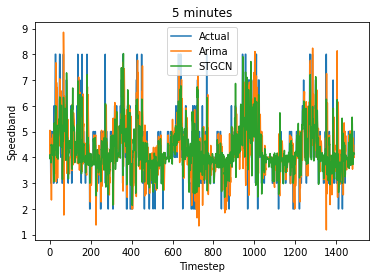

In [182]:
plot5mnt(actual_denorm[:,road,:],arima_pred,predicted_denorm[:,road,:])

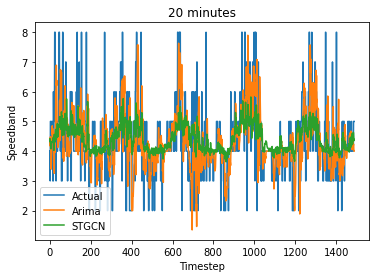

In [183]:
plot20mnt(actual_denorm[:,road,:],arima_pred,predicted_denorm[:,road,:])